# Take sample of articles based on classification scores for org. science perspectives

@author: Jaren Haber, PhD<br>
@coauthors: Prof. Heather Haveman, UC Berkeley; Yoon Sung Hong, Wayfair<br>
@contact: Jaren.Haber@georgetown.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@repo: https://github.com/h2researchgroup/classification/<br>
@date: December 2020

'''
Uses classifiers trained on labeled articles (uses a perspective or not) to select a sample of articles (of given length) per perspective (cultural, relational, and demographic) for hand-labeling. Data source is full academic articles in sociology or management/org. behavior from JSTOR. For the first batch using this script, 90% of these selected articles are predicted to be of the minority class for that perspective, which is 'yes' for all three. The remaining 10% are from majority class, which are easier to predict in our skewed first batch of data. Future batches may use a more balanced sampling procedure. 
'''

## Initialize

In [1]:
# Install anything not already in server
#!pip install nltk
#!pip install --upgrade scikit-learn # need to update sklearn for Jaren's VM

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import time
import random
random.seed(43)

import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
import math

import sys; sys.path.insert(0, "../preprocess/") # For loading functions from files in other directory
#from clean_text import stopwords_make, punctstr_make, unicode_make, apache_tokenize, clean_sentence_apache # for preprocessing text
from quickpickle import quickpickle_dump, quickpickle_load # custom scripts for quick saving & loading to pickle format
from text_to_file import write_textlist, read_text # custom scripts for reading and writing text lists to .txt files

In [13]:
######################################################
# Define filepaths
######################################################

thisday = date.today().strftime("%m%d%y")

cwd = os.getcwd()
root = str.replace(cwd, 'classification/modeling', '')

# Directory for prepared data and trained models: save files here
data_fp = root + 'classification/data/'
model_fp = root + 'classification/models/'

# Current article lists
article_list_fp = data_fp + 'filtered_length_index.csv' # Filtered index of research articles
article_paths_fp = data_fp + 'filtered_length_article_paths.csv' # List of article file paths
article_names_fp = data_fp + 'filtered_length_article_names.xlsx' # Filtered list of article names and general data, sorted by journal then article name

# Path to ALL JSTOR preprocessed text
all_prepped_fp = data_fp + 'filtered_preprocessed_texts_65365_120720.pkl'

# Path to predictions for each perspective
predicted_fp = model_fp + 'predictions_RF_65365_121420.pkl'

# Per-article metadata with year and URL info
meta_fp = root + 'dictionary_methods/code/metadata_combined.h5' 

n_sample = 150 # 50 per perspective

# Output: Sample for hand-coding
sample_fp = data_fp + f'coding_sample_{str(n_sample)}_{str(thisday)}.pkl'

## Load & merge data

In [9]:
# Read in metadata file
df_meta = pd.read_hdf(meta_fp)
df_meta.reset_index(drop=False, inplace=True) # extract file name from index

# For merging purposes, get ID alone from file name, e.g. 'journal-article-10.2307_2065002' -> '10.2307_2065002'
df_meta['edited_filename'] = df_meta['file_name'].apply(lambda x: x[16:]) 
df_meta = df_meta[["edited_filename", "article_name", "jstor_url", "abstract", "journal_title", "given_names", "primary_subject", "year", "type"]] # keep only relevant columns

df_meta.head()

,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type
0,10.2307_4167860,Cross-Dialectal Variation in Arabic: Competing...,https://www.jstor.org/stable/4167860,Most researchers of Arabic sociolinguistics as...,Language in Society,None,Other,1979,research-article
1,10.2307_2578336,None,https://www.jstor.org/stable/2578336,None,Social Forces,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1983,book-review
2,10.2307_2654760,None,https://www.jstor.org/stable/2654760,None,Contemporary Sociology,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1998,book-review
3,10.2307_43242281,editor's note: A KNIGHT'S TALE,https://www.jstor.org/stable/43242281,None,Corporate Knights,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Other,2005,misc
4,10.2307_42862018,None,https://www.jstor.org/stable/42862018,None,Social Science Quarterly,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1985,book-review


In [22]:
# Read in filtered index
df = pd.read_csv(article_list_fp, low_memory=False, header=None, names=["file_name"])
df['edited_filename'] = df['file_name'].apply(lambda x: x[16:]) # New col with only article ID

# Read predictions using latest models
df_pred = quickpickle_load(predicted_fp)

# For consistency across data sources, rename absolute file path to 'file_path' and create shorter 'file_name'
df_pred['file_path'] = df_pred['file_name'] # rename for consistency across files
df_pred['file_name'] = df_pred['file_name'].str.replace(
    '/vol_b/data/jstor_data/ocr/', '').str.replace('.txt', '') # remove folders + file suffix

# Merge meta data, predictions into articles list DF
df = pd.merge(df, df_meta, how='left', on='edited_filename') # meta data
df = pd.merge(df, df_pred, how='right', on='file_name') # predictions

# Show all columns in resulting DF
print("All columns:\n", list(df))
print()

print("Rows, cols in data:", df.shape)

df.head()

All columns:
 ['file_name', 'edited_filename', 'article_name', 'jstor_url', 'abstract', 'journal_title', 'given_names', 'primary_subject', 'year', 'type', 'prediction_cult', 'prediction_cult_prob_yes', 'prediction_cult_prob_no', 'prediction_relt', 'prediction_relt_prob_yes', 'prediction_relt_prob_no', 'prediction_demog', 'prediction_demog_prob_yes', 'prediction_demog_prob_no', 'file_path']

Rows, cols in data: (65365, 20)


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type,prediction_cult,prediction_cult_prob_yes,prediction_cult_prob_no,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,file_path
0,journal-article-10.2307_2065002,10.2307_2065002,Toward More Cumulative Inquiry,https://www.jstor.org/stable/2065002,None,Contemporary Sociology,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1978,research-article,no,0.03,0.97,no,0.02,0.98,no,0.02,0.98,/vol_b/data/jstor_data/ocr/journal-article-10....
1,journal-article-10.2307_3380821,10.2307_3380821,An Analysis of an Incentive Sick Leave Policy ...,https://www.jstor.org/stable/3380821,Local health departments are under tremendous ...,Public Productivity & Management Review,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Management & Organizational Behavior,1986,research-article,no,0.05,0.95,no,0.04,0.96,no,0.01,0.99,/vol_b/data/jstor_data/ocr/journal-article-10....
2,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,no,0.01,0.99,no,0.05,0.95,no,0.01,0.99,/vol_b/data/jstor_data/ocr/journal-article-10....
3,journal-article-10.2307_40836133,10.2307_40836133,Knowledge Transfer within the Multinational Fi...,https://www.jstor.org/stable/40836133,This paper examines the process of knowledge t...,MIR: Management International Review,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Management & Organizational Behavior,2005,research-article,no,0.01,0.99,no,0.01,0.99,no,0.01,0.99,/vol_b/data/jstor_data/ocr/journal-article-10....
4,journal-article-10.2307_2579666,10.2307_2579666,Dynamics of Labor Market Segmentation in Polan...,https://www.jstor.org/stable/2579666,Research in the early 1980s showed that indust...,Social Forces,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1990,research-article,no,0.02,0.98,no,0.01,0.99,no,0.02,0.98,/vol_b/data/jstor_data/ocr/journal-article-10....


## Visualize distributions of labels

In [23]:
def calculate_threshold(num_to_find, series):
    '''
    Calculates greatest threshold to find requested number of texts in a dataframe series
    
    Args:
        tweets_to_find: number of tweets to find
        df: df series to search through
    Returns:
        threshold: minimum value of probability
    
    '''
    threshold = .500
    texts_num = series[series > threshold].size
    
    while num_to_find > texts_num:
        threshold = round(threshold - .001,3)
        texts_num = series[series > threshold].size
        
    return threshold

### Cultural perspective

In [46]:
# Show predicted labels
pred_col = 'prediction_cult'
df[pred_col].value_counts()

no    65365
Name: prediction_cult, dtype: int64

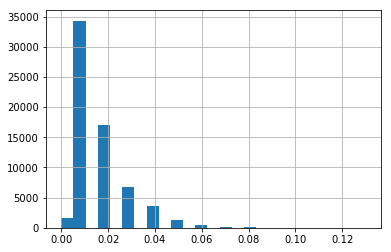

In [47]:
# Minority Class (yes) Distribution
prob_col = 'prediction_cult_prob_yes'
df[prob_col].hist(bins=25)

In [57]:
# Look at top_n most likely cases for using this perspective
top_n = 60
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

0.139% (91) of cases are above 0.079


### Relational perspective

In [42]:
# Show predicted labels
pred_col = 'prediction_relt'
df[pred_col].value_counts()

no    65365
Name: prediction_relt, dtype: int64

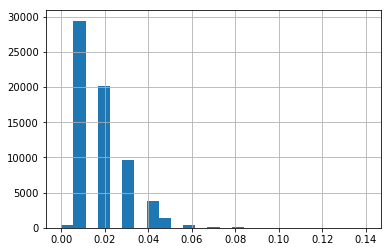

In [34]:
# Minority Class (yes) Distribution
prob_col = 'prediction_relt_prob_yes'
df[prob_col].hist(bins=25)

In [35]:
# Look at top_n most likely cases for using this perspective
top_n = 60
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

0.095% (62) of cases are above 0.089


### Demographic perspective

In [43]:
# Show predicted labels
pred_col = 'prediction_demog'
df[pred_col].value_counts()

no    65365
Name: prediction_demog, dtype: int64

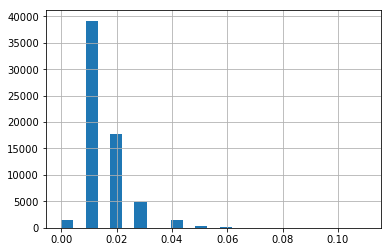

In [36]:
# Minority Class (yes) Distribution
prob_col = 'prediction_demog_prob_yes'
df[prob_col].hist(bins=25)

In [37]:
# Look at top_n most likely cases for using this perspective
top_n = 60
threshold = calculate_threshold(top_n, df[prob_col])
num = len(df[df[prob_col] > threshold])
prop = (num/len(df))*100 
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

0.101% (66) of cases are above 0.069


## Select articles for sample

Get sample of 150 new articles (50 per perspective), composed of 90% minority class and 10% majority class.<br>
To improve fidelity of model, make the tweets selected majority class fuzzy/unreliable, so model gets better at labeling these.<br>
First, filter into new DFs, one for minority class and one for (fuzzy) majority class.

In [39]:
# set thresholds for minority cases for each myth
# set these as low as possible to capture ~45 tweets likely to fall in minority class
capture_num = 60
minority_threshold_dis = calculate_threshold(capture_num,final_df['prediction_dis_prob_yes'])
minority_threshold_rem = calculate_threshold(capture_num,final_df['prediction_rem_prob_yes'])
minority_threshold_wth = calculate_threshold(capture_num,final_df['prediction_wth_prob_yes'])

# filter using threshold
df_dis_minority = final_df[final_df['prediction_dis_prob_yes'] > minority_threshold_dis]
df_rem_minority = final_df[final_df['prediction_rem_prob_yes'] > minority_threshold_rem]
df_wth_minority = final_df[final_df['prediction_wth_prob_yes'] > minority_threshold_wth]

# check out results
print('Number of minority cases selected for each myth:')
print(f'{len(df_dis_minority)} for disinfectants')
print(f'{len(df_rem_minority)} for home remedies')
print(f'{len(df_wth_minority)} for weather')

Number of minority cases selected for each myth:
162 for disinfectants
164 for home remedies
1631 for weather


In [40]:
def check_pred_fuzzy(row, 
                     pred_labels = ['yes', 'no'], 
                     myth_labels = ['dis', 'rem', 'wth'],
                     upper_threshold=0.3, 
                     lower_threshold=0.10):
    
    '''
    Checks whether prediction is fuzzy/unreliable. Use this to determine if a tweet is worth hand-coding.
    Rationale: by only coding tweets with unreliable labels, we can improve the classifier's ability to detect 'unsure' cases.
    
    Function focuses on this difference: prob(predicted label) - prob(some other label).
    If difference is greater than lower_threshold (minimum for hand-coding of tweet to be possible), 
    but lesser than upper_threshold (maximum for hand-coding to be necessary), then it IS worth coding, so return True. 
    If difference is not between these, then we either it can't be reliably coded, or already have a reliable prediction,
    so we don't need to hand-code --> return False.

    To help select a threshold, ask: To what extent do we want the uncertainty to be, to help inform our sample selection?    
    For example, if a tweet is labeled as POS with 90% prob and NEG 10% --> this is very obvious sample, so don't bother coding.
    On the other hand, if the predictions are 51% NEG and 49 POS, then we need ppl to label this to update our model. 
    If our upper_threshold is 20% (0.20), then if a tweet has 61% NEG 39% POS probabilities, we don't choose it. 
    If some other tweet has prob 59% POS 41% NEG, we do select it for coding.
    
    Args:
        row: row corresponding to tweet, with predictions in format...
        pred_labels: labels for probabilities to use--used for naming columns
        myth_labels: labels for COVID-19 myths to detect--used for naming columns
        upper_threshold: max difference between predicted probs
        lower_threshold: min difference between predicted probs
    
    Returns:
        Array: True if tweet should be hand-coded, otherwise False. Array contains determinations for all myths
    '''
    
    worth_coding = []
    
    for myth in myth_labels:
        pred_label = row[f'prediction_{myth}'].strip() # get label of prediction for tweet--must be one of those in possible_labels!
        pred_score = float(row[f'prediction_{myth}_prob_{pred_label}']) # get probability of predicted label (probably high)
        
        for pred in pred_labels: # Look at each label
            pred = pred.strip() # clean label text
            
            if pred != pred_label: # if this label isn't the predicted one...
                difference = pred_score - float(row[f'prediction_{myth}_prob_{pred}']) # ...then look at their difference in probability
                if lower_threshold <= difference <= upper_threshold:
                 # if difference in probs is > lower_threshold but < upper_threshold, then pred is fuzzy and we should code
                    worth_coding.append(True) # worth coding
                
                else: worth_coding.append(False)
                    
    if len(worth_coding) == 1:
        return worth_coding[0]
    
    else: return worth_coding

In [41]:
df_dis_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['dis'], upper_threshold = .65), axis=1)]      
df_rem_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['rem'], upper_threshold = .65), axis=1)]
df_wth_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['wth'], upper_threshold = .65), axis=1)]
print(f'df_dis_fuzzy: {df_dis_fuzzy.shape}')
print(f'df_rem_fuzzy: {df_rem_fuzzy.shape}')
print(f'df_wth_fuzzy: {df_wth_fuzzy.shape}')

100%|██████████| 1631/1631 [00:00<00:00, 61658.70it/s]

df_dis_fuzzy: (75, 13)
df_rem_fuzzy: (122, 13)
df_wth_fuzzy: (20, 13)


## Compile sample

In [42]:
def sample_tweets(df, df_minority, df_fuzzy, sample_size=150, prop_maj=.1):
    '''
    Preliminary script to sample tweets using the previously determined minority and fuzzy df.
    Does not take into account distribution of dates.
    
    Args:
        df: original df with tweet id and full text
        df_minority: minority df with tweets above threshold
        sample_size: number of total tweets to sample
        prop_maj: proportion of total tweets to be majority label/fuzzy
        
    '''
    df_sample = pd.DataFrame()
    min_size = int(sample_size * (1-prop_maj))
    maj_size = sample_size - min_size
    
    for id in tqdm(df_minority['id'].sample(n=min_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
    for id in tqdm(df_minority['id'].sample(n=maj_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
#     df_sample = df_sample.rename(columns={'id': 'tweet_id'})
    df_sample = df_sample.sample(frac=1).reset_index(drop=True)
    return df_sample

dis_sample = sample_tweets(final_df,df_dis_minority,df_dis_fuzzy, sample_size = n_sample)
print(dis_sample.head(5))
rem_sample = sample_tweets(final_df,df_rem_minority,df_rem_fuzzy, sample_size = n_sample)
print(rem_sample.head(5))
wth_sample = sample_tweets(final_df,df_wth_minority, df_wth_fuzzy, sample_size = 280)
print(wth_sample.head(5))

 29%|██▉       | 47/162 [00:00<00:00, 464.74it/s]

                    id                created_at  \
0  1252363412497027078 2020-04-20 22:27:59+00:00   
1  1252363943449788417 2020-04-20 22:30:06+00:00   
2  1252202084541231105 2020-04-20 11:46:56+00:00   
3  1252209617020444678 2020-04-20 12:16:52+00:00   
4  1290804398935998464 2020-08-05 00:18:45+00:00   

                                           full_text  
0  Sick bastards. Spread this. #2019nCoV #COVID19...  
1  So sad. Looks like we got the flow out of hosp...  
2  ITS NORMAL TO FEEL SAD, STRESSED AND CONFUSED ...  
3  😷 TAIWAN: ❝Virus Outbreak: Social distancing l...  
4  How does @christufton, @themohwgovjm or even G...  


 18%|█▊        | 45/252 [00:00<00:00, 439.86it/s]

                    id                created_at  \
0  1262535766741139457 2020-05-19 00:09:18+00:00   
1  1279393572303900672 2020-07-04 12:36:12+00:00   
2  1290803454688890880 2020-08-05 00:15:00+00:00   
3  1252177328219672577 2020-04-20 10:08:34+00:00   
4  1252177073650589696 2020-04-20 10:07:33+00:00   

                                           full_text  
0  Plenty Pre-#COVID19 patients who'd been using ...  
1  @10DowningStreet Preliminary investigations co...  
2  “Doctors believe many people are fighting #Cov...  
3  New article: Strategies for Prevention of Coro...  
4  New article: Association of the COVID-19 pande...  


100%|██████████| 28/28 [00:00<00:00, 435.89it/s]

                    id                created_at  \
0  1279217386881720321 2020-07-04 00:56:06+00:00   
1  1294791116886167552 2020-08-16 00:20:32+00:00   
2  1262535512247730176 2020-05-19 00:08:17+00:00   
3  1279269617693863936 2020-07-04 04:23:39+00:00   
4  1262535494308712449 2020-05-19 00:08:13+00:00   

                                           full_text  
0  They played with lives of people for their pol...  
1  Dangerous ill-informed advisories from @CDC. I...  
2  ⭐️⭐️🇺🇸⭐️⭐️\nDear Plexiglas maker of ... well.....  
3  @SEKCSF @Pote78399148 @pigson0127 Can we retur...  
4  "seroprevalence study in Los Angeles County fi...  


### Check date distribution and remove column

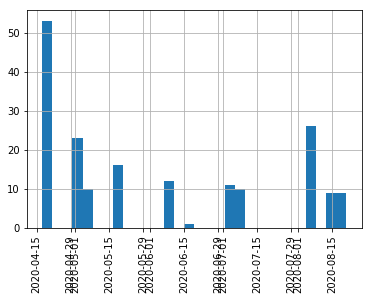

In [43]:
dis_sample['created_at'].hist(bins = 30, xrot = 90)
dis_sample.drop(columns = 'created_at', inplace = True)

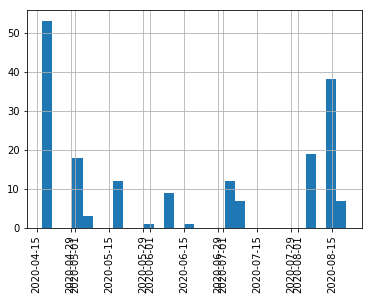

In [44]:
rem_sample['created_at'].hist(bins = 30, xrot = 90)
rem_sample.drop(columns = 'created_at', inplace = True)

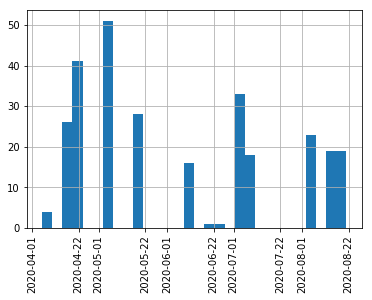

In [45]:
wth_sample['created_at'].hist(bins = 30, xrot = 90)
wth_sample.drop(columns = 'created_at', inplace = True)

## Save to file

In [48]:
dis_sample.to_csv(dis_sam_fp,\
    escapechar='\"', \
    quotechar='\"',\
    quoting=csv.QUOTE_ALL,\
    index=False)
# rem_sample.to_csv(rem_sam_fp,\
#     escapechar='\"', \
#     quotechar='\"',\
#     quoting=csv.QUOTE_ALL,\
#     index=False)
# wth_sam_fp = f'../data/sample_280_tweets_weather_{str(thisday)}.csv'
# wth_sample.to_csv(wth_sam_fp,\
#     escapechar='\"', \
#     quotechar='\"',\
#     quoting=csv.QUOTE_ALL,\
#     index=False)